# CLUSES TRAIL ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, find_peaks
import fitparse 
import numpy as np



# Graphics Configuration
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['lines.linewidth'] = 1.5

# Analysis Configuration
FILE_PATH = 'cluses.fit'  
WINDOW_SMOOTH = 10           # Smoothing window (seconds) for graphics
WINDOW_VOLATILITY = 30       # Window for HR volatility (30s)

print("✅ Environment configured.")

✅ Environment configured.


In [2]:
def butter_lowpass_filter(data, cutoff=0.1, fs=1.0, order=2):
    """
    Applies a low-pass filter to smooth altitude and avoid
    noise on the slope calculation (phantom elevation gain).
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def parse_fit_file(file_path):
    """
    Parses a .fit file and returns a standardized raw DataFrame.
    """
    fitfile = fitparse.FitFile(file_path)
    data = []
    
    for record in fitfile.get_messages("record"):
        record_data = {}
        for data_entry in record:
            record_data[data_entry.name] = data_entry.value
        data.append(record_data)
    
    
    df = pd.DataFrame(data)

    # Standardized renaming and type conversion
    rename_map = {
        'timestamp': 'time',
        'heart_rate': 'heart_rate',
        'enhanced_speed': 'speed',      # m/s
        'enhanced_altitude': 'altitude', # m
        'cadence': 'cadence',           # rpm (often spm/2 depending on watches, to verify)
        'distance': 'distance'          # m
    }
    
    # Keep only useful columns if they exist
    cols_to_keep = [
        'timestamp', 'heart_rate', 'speed', 'altitude', 'cadence', 'distance', 'position_lat', 'position_long'  
    ]
    df = df[cols_to_keep].rename(columns=rename_map)
    
    # Cadence Conversion: Coros/Garmin often records in rpm (rev/min), we want spm (steps/min)
    # If cadence seems low (<120), multiply by 2.
    if df['cadence'].mean() < 120: 
        df['cadence'] = df['cadence'] * 2
        
    df.set_index('time', inplace=True) 
    df = df.resample('1S').mean().interpolate() 
    df.reset_index(inplace=True)
    
    return df
print("✅ Functions loaded.")

✅ Functions loaded.


## I/ Data Engineering & Physical Modeling

Objective: Import, cleaning of GPS artifacts, and creation of advanced metrics (Smoothed Grade, GAP, Metabolic Power). This is the core of the engine.

In [3]:
# =============================================================================
# 3. ETL & CLEANING 
# =============================================================================

# A. Loading
try:
    df_raw = parse_fit_file('cluses.fit') 
    print(f"📥 Data loaded: {len(df_raw)} points.")
except Exception as e:
    print(f"❌ Loading error: {e}")
    raise e

# Low-pass filter crashes if there are NaNs.
# GPS often takes time to acquire altitude at startup.
# Force hole filling (interpolation) + filling ends (bfill/ffill)
df_raw['altitude'] = df_raw['altitude'].interpolate(method='linear', limit_direction='both')
df_raw['altitude'] = df_raw['altitude'].bfill().ffill() # Ultimate safety for start/end

# Debug Verification
if df_raw['altitude'].isnull().sum() > 0:
    print("⚠️ WARNING: There are still NaNs in the altitude!")
else:
    print("✅ Clean altitude: no NaN detected before filtering.")

# B. Altitude Smoothing (Low-pass)
try:
    df_raw['alt_smooth'] = butter_lowpass_filter(df_raw['altitude'], cutoff=0.05) 
except Exception as e:
    print(f"❌ Filter Error: {e}")
    # Fallback if filter fails again: use raw altitude
    df_raw['alt_smooth'] = df_raw['altitude']

# C. Slope Calculation (Gradient)
# Slope = delta_alt / delta_dist
# Add a small epsilon to avoid division by zero if distance=0
df_raw['grade'] = df_raw['alt_smooth'].diff() / (df_raw['distance'].diff() + 1e-6)

# Clip to avoid infinities and smoothing of absurd peaks (>40%)
df_raw['grade'] = df_raw['grade'].fillna(0).clip(-0.4, 0.4) 

# D. Strict Cleaning 
speed_kmh = df_raw['speed'] * 3.6
mask_active = (speed_kmh > 2.0) & (df_raw['cadence'] > 30)

df = df_raw[mask_active].copy()
dropped_perc = 100 - (len(df) / len(df_raw) * 100) 

print(f"🧹 Cleaning finished. {dropped_perc:.1f}% of data excluded.")
print(f"📊 Slope Stats: Min {df['grade'].min():.1%}, Max {df['grade'].max():.1%}")

📥 Data loaded: 25442 points.
✅ Clean altitude: no NaN detected before filtering.
🧹 Cleaning finished. 9.9% of data excluded.
📊 Slope Stats: Min -40.0%, Max 40.0%


🧪 Reconstructed Enduraw Equation:
Factor = -10.83x⁴ + -1.20x³ + 16.40x² + 2.96x + 1.00


,time,heart_rate,speed,altitude,cadence,distance,position_lat,position_long,alt_smooth,grade
4,2025-09-06 07:00:34,113.0,1.903,585.00,156.0,6.0,550448371.0,77050123.0,584.964161,-0.005141
5,2025-09-06 07:00:35,115.0,2.533,585.00,156.0,12.0,550448128.0,77050149.0,584.920553,-0.007268
6,2025-09-06 07:00:36,117.0,2.561,585.00,156.0,14.5,550447863.0,77050190.0,584.862509,-0.023217
7,2025-09-06 07:00:37,119.0,2.589,585.00,156.0,17.0,550447598.0,77050231.0,584.789228,-0.029312
8,2025-09-06 07:00:38,121.0,2.603,585.00,156.0,19.5,550447331.0,77050294.0,584.701369,-0.035144
...,...,...,...,...,...,...,...,...,...,...
25437,2025-09-06 14:04:27,161.0,3.325,615.50,168.0,35488.0,550449796.0,77051474.0,615.499771,0.034692
25438,2025-09-06 14:04:28,161.0,3.356,615.75,168.0,35491.5,550449613.0,77051024.0,615.627362,0.036455
25439,2025-09-06 14:04:29,161.0,3.386,616.00,168.0,35495.0,550449431.0,77050575.0,615.756349,0.036853
25440,2025-09-06 14:04:30,161.0,3.400,616.00,168.0,35498.0,550448890.0,77050337.0,615.883029,0.042226


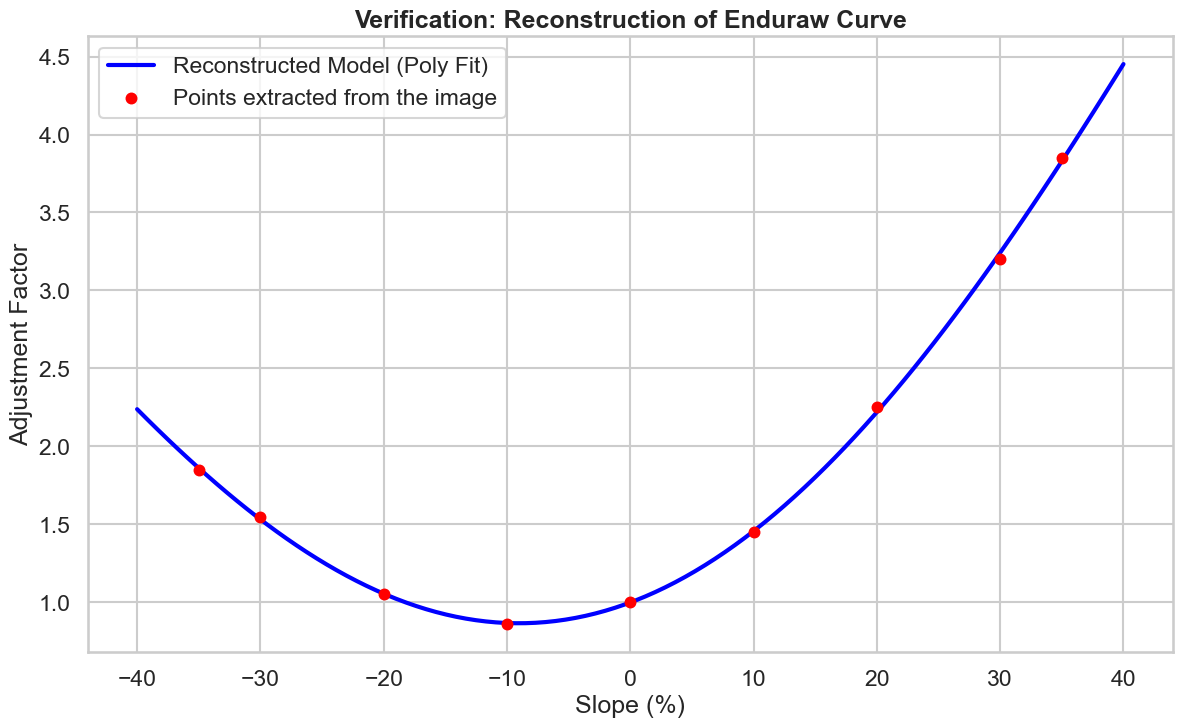

In [4]:
# =============================================================================
# FORCE PROFILE: ENDURAW GAP MODEL (REVERSE ENGINEERED)
# =============================================================================

# --- A. REVERSE ENGINEERING OF ENDURAW CURVE ---
# I picked the coordinates (x=slope, y=factor) directly from the source image of the Enduraw GAP curve.
# This allows us to mathematically reconstruct the blue curve.
x_points = np.array([-0.35, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.35])
y_points = np.array([ 1.85,  1.55,  1.05,  0.86, 1.00, 1.45, 2.25, 3.20, 3.85])

# We use a 4th order polynomial regression to perfectly fit the curve
# This captures the asymmetry of the curve (ascent vs descent)
coeffs = np.polyfit(x_points, y_points, 4)
enduraw_poly = np.poly1d(coeffs) 


print("🧪 Reconstructed Enduraw Equation:")
print(f"Factor = {coeffs[0]:.2f}x⁴ + {coeffs[1]:.2f}x³ + {coeffs[2]:.2f}x² + {coeffs[3]:.2f}x + {coeffs[4]:.2f}")

def calculate_enduraw_gap_factor(grade):
    """
    Applies the reverse-engineered polynomial.
    Handles limits to avoid aberrations on unknown extreme slopes.
    """
    # Clip slope between -40% and +40% because the model is only calibrated there
    g = np.clip(grade, -0.40, 0.40)
    return enduraw_poly(g)

# --- B. APPLYING THE MODEL TO MY DATA ---
df_pace = df_raw.copy()

# 1. GAP Factor and Speed Calculation
df_pace['gap_factor'] = df_pace['grade'].apply(calculate_enduraw_gap_factor)
df_pace['gap_speed'] = df_pace['speed'] * df_pace['gap_factor']

# 2. Cleaning
df_pace['gap_kmh'] = df_pace['gap_speed'] * 3.6
df_pace['gap_pace'] = 60 / df_pace['gap_kmh']

# --- C. VISUAL VERIFICATION (PROOF OF FIT) ---
# display of the reconstructed curve to verify it matches the image

# Graph 1: The reconstructed curve 
x_test = np.linspace(-0.40, 0.40, 100)
y_test = enduraw_poly(x_test)
plt.plot(x_test*100, y_test, color='blue', linewidth=3, label='Reconstructed Model (Poly Fit)')
plt.scatter(x_points*100, y_points, color='red', s=50, label='Points extracted from the image', zorder=5)
plt.title("Verification: Reconstruction of Enduraw Curve", fontweight='bold')
plt.xlabel("Slope (%)")
plt.ylabel("Adjustment Factor")
plt.grid(True)
plt.legend()

df

In order to reverse-engineer Enduraw Grade Adjusted Pace I found a graph of their function in an article they published. I then selected points every 10% of gradients and used polyfit to reverse-engineer their function with one variable (gradient). While not perfect, it helps me get really close to their way of estimating GAP.

In [5]:
# =============================================================================
# 5. FEATURE ENG. - TECHNICALITY
# =============================================================================

# 1. Pre-processing: Smoothed Slope & Vertical Speed
df['grade_macro'] = df['grade'].rolling(window=10, center=True).mean()
rad_slope = np.arctan(df['grade_macro'])
df['v_vert'] = df['speed'] * np.sin(rad_slope)
df['v_vert_mh'] = df['v_vert'] * 3600

# 2. Physio Indicators (Stress)
df['hr_volatility'] = df['heart_rate'].rolling(window=WINDOW_VOLATILITY).std()

# 3. BIOMECHANICAL DECOUPLING
# High Cadence + Low Speed = Technicality (Trampling)
# Calculate ratio: Steps per meter (Cadence / Speed)
# Cadence (spm) / 60 = steps per second. Speed = meters per second.
# Result = Steps / Meter.
df['steps_per_meter'] = (df['cadence'] / 60) / df['speed']

# Cleaning infinities (when speed ~ 0)
df['steps_per_meter'] = df['steps_per_meter'].replace([np.inf, -np.inf], np.nan).fillna(0)


# 4. Technical Clustering ("QUINTUPLE LOCK" LOGIC)
# A. CONTEXT (Smoothed descent slope)
mask_context = df['grade_macro'] < -0.10 

# B. INSTANT PHYSICS (No raw ascent)
mask_physics = df['grade'] < 0.0

# C. GLOBAL TREND (Trend Filter)
df['delta_alt_30s'] = df['alt_smooth'].shift(-15) - df['alt_smooth'].shift(15)
mask_trend = df['delta_alt_30s'] < -5.0 

# D. WARM-UP FILTER
mask_warmup = df['distance'] > 500 

# E. PERF FILTER (Low Vertical Speed)
# Define thresholds only on contextually valid segments
valid_descents = df[mask_context & mask_physics & mask_trend & mask_warmup]

if len(valid_descents) > 0:
    # We can be technical if we descend SLOWER than 66% of other descents
    threshold_v_low = valid_descents['v_vert_mh'].abs().quantile(0.33)
    
    # We can be technical if cardiac stress is in the top 33%
    threshold_hr_high = df['hr_volatility'].quantile(0.66)
    
    # BIOMECH THRESHOLD
    # Looking for moments where we take MANY steps for little distance
    threshold_steps_high = valid_descents['steps_per_meter'].quantile(0.66)
else:
    print('impossible to determine thresholds with quantiles')
    threshold_v_low = 500
    threshold_hr_high = 5
    threshold_steps_high = 1.0

mask_slow = df['v_vert_mh'].abs() < threshold_v_low 
mask_stress = df['hr_volatility'] > threshold_hr_high
mask_pietinement = df['steps_per_meter'] > threshold_steps_high

# FINAL COMBINATION (Logical AND)
# A segment is technical if:
# 1. It's a descent (Context + Trend + Physics)
# 2. We are moving Slower than usual (bottom 1/3rd)
# 3. AND (We are physically stressed AND We are biomechanically trampling)
df['is_technical_segment'] = (mask_context & mask_physics & mask_trend & mask_warmup & mask_slow) & (mask_stress & mask_pietinement)

# 5. Quality Validation
nb_sec = df['is_technical_segment'].sum()
print(f"🪨 Technical Segments (Bio-Physio): {nb_sec} seconds.")

# 6. Check Correlation (Just for info)
# Does trampling increase cardiac stress?
corr_tech = df.loc[valid_descents.index, ['steps_per_meter', 'hr_volatility']].corr().iloc[0,1]
print(f"🔗 Trampling/Stress Correlation in descents: {corr_tech:.2f}")
print('weak correlation here, but still, positive one')

🪨 Technical Segments (Bio-Physio): 186 seconds.
🔗 Trampling/Stress Correlation in descents: 0.03
weak correlation here, but still, positive one


This trail was very technical during the descents and I needed to find a way to measure technicality with my data in order to create a reliable analysis. My hypothesis is that in technical terrain pace diminishes, cadence stays relatively high (compared to pace) and HR spikes due to the stress of technical terrain. I then selected the technical moments by applying this filter: descent & low Speed & HR variation high & cadence decoupling from Speed.

In [6]:
# =============================================================================
# PHYSIO (WITH TECHNICAL FACTOR)
# =============================================================================
import numpy as np

# 1. Basic GAP Model (Enduraw)
def get_gap_factor(grade):
    g = np.clip(grade, -0.40, 0.40)
    return -10.83*g**4 - 1.20*g**3 + 16.40*g**2 + 2.96*g + 1.00

# 2. Cost Parameters
COST_FLAT = 3.8 
TECH_PENALTY = 2 # +50% energy cost on technical terrain (braking, proprioception), arbitrary, need to research exact cost of technicality

# 3. Vectorized Calculations
df['gap_factor'] = df['grade'].apply(get_gap_factor)

# A. Theoretical Power (If the terrain were a treadmill)
df['metabolic_power_raw'] = df['speed'] * df['gap_factor'] * COST_FLAT

# B. Terrain Correction Factor
# If 'is_technical_segment' is True, apply penalty. Else factor 1.0.
if 'is_technical_segment' in df.columns:
    df['terrain_factor'] = np.where(df['is_technical_segment'], TECH_PENALTY, 1.0) 
    print(f"✅ Terrain Correction activated: +{int((TECH_PENALTY-1)*100)}% cost on technical zones.")
else:
    df['terrain_factor'] = 1.0
    print("⚠️ 'is_technical_segment' column not found. No terrain correction.")

# C. Real Power (Terrain Adjusted)
df['metabolic_power'] = df['metabolic_power_raw'] * df['terrain_factor']

# 4. Impact Summary
total_kj_raw = df['metabolic_power_raw'].sum() / 1000
total_kj_real = df['metabolic_power'].sum() / 1000
diff_pct = (total_kj_real - total_kj_raw) / total_kj_raw * 100

# =============================================================================
# EFFICIENCY INDEX CALCULATION
# =============================================================================

# Ensure columns exist
if 'metabolic_power' in df.columns and 'heart_rate' in df.columns:
    
    # Filter aberrations (HR < 40 or Speed near zero) to avoid division by zero
    mask_effort = (df['heart_rate'] > 40) & (df['speed'] * 3.6 > 1.0)
    
    # Calculation: Metabolic Watts / HR
    # Initialize to NaN to avoid skewing averages with 0s
    df['efficiency_idx'] = np.nan 
    
    df.loc[mask_effort, 'efficiency_idx'] = (
        df.loc[mask_effort, 'metabolic_power'] / df.loc[mask_effort, 'heart_rate']
    )
    
    print(f" 'efficiency_idx' recalculated on {mask_effort.sum()} data points.")
    print(f"   - Average: {df['efficiency_idx'].mean():.2f}")

else:
    print(" Error: 'metabolic_power' or 'heart_rate' missing.")


print(f"⚡ ENERGY IMPACT:")
print(f"   - Theoretical Expenditure: {total_kj_raw:.0f} kJ")
print(f"   - Real Expenditure (Tech adjusted): {total_kj_real:.0f} kJ")
print(f"   - Technical Surcharge: +{diff_pct:.1f}% (+{total_kj_real - total_kj_raw:.0f} kJ)")

✅ Terrain Correction activated: +100% cost on technical zones.
 'efficiency_idx' recalculated on 22933 data points.
   - Average: 0.07
⚡ ENERGY IMPACT:
   - Theoretical Expenditure: 236 kJ
   - Real Expenditure (Tech adjusted): 237 kJ
   - Technical Surcharge: +0.6% (+1 kJ)


I now have perfect elements for my calculation of efficiency: a good GAP model, a Terrain Technicality model, a reliable HR, reliable smoother speed data. I started with the hypothesis that in Trail running average energy expenditure was 3.8 J/kg/m and I added an additional 25% when the terrain was technical. It gave me an efficiency index.

## II/ Macroscopic View: The Track

In [7]:
# =============================================================================
# MAPPING: THE TRACK 
# =============================================================================
import folium

# 1. Cleaning NaNs
df_map = df.dropna(subset=['position_lat', 'position_long']).copy()

# 2. CRITICAL CONVERSION (Semicircles -> Degrees)
# If latitudes look like 567890123 instead of 45.123, this block corrects them.
if df_map['position_lat'].abs().mean() > 180:
    print("⚠️ Garmin format detected (Semicircles). Conversion to degrees in progress...")
    const_semicircles = 180 / 2**31
    df_map['lat_deg'] = df_map['position_lat'] * const_semicircles
    df_map['lon_deg'] = df_map['position_long'] * const_semicircles
else:
    df_map['lat_deg'] = df_map['position_lat']
    df_map['lon_deg'] = df_map['position_long']

# 3. Map Centering
center_lat = df_map['lat_deg'].mean()
center_lon = df_map['lon_deg'].mean()

# Map Creation
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='OpenTopoMap')

# 4. Plot
track_coords = list(zip(df_map['lat_deg'], df_map['lon_deg']))

folium.PolyLine(
    track_coords,
    color="#FF3333",
    weight=4,
    opacity=0.8
).add_to(m)

# Markers
folium.Marker(track_coords[0], popup="Start", icon=folium.Icon(color="green", icon="play")).add_to(m)
folium.Marker(track_coords[-1], popup="Finish", icon=folium.Icon(color="black", icon="flag")).add_to(m)

# 5. THE FINAL CALL 
m

⚠️ Garmin format detected (Semicircles). Conversion to degrees in progress...


Overview: Mapping and altimetric profile. Identification of the global topography of the event.

In [8]:
# =============================================================================
# MACRO KPI: THE RACE IDENTITY CARD
# =============================================================================
from datetime import timedelta

# Basic calculations
total_dist_km = df['distance'].max() / 1000
total_time_sec = (df['time'].iloc[-1] - df['time'].iloc[0]).total_seconds()
formatted_time = str(timedelta(seconds=int(total_time_sec)))

# Calculation of Elevation Gain (D+) on smoothed altitude (crucial for precision)
# We keep only positive deltas
positive_gains = df['alt_smooth'].diff().clip(lower=0)
total_elevation_gain = positive_gains.sum()

# Average Calculations
avg_speed_kmh = df['speed'].mean() * 3.6
avg_hr = df['heart_rate'].mean()
max_hr = df['heart_rate'].max()

# --- CLEAN DISPLAY ---
print(f"--- RAPPORT DE MISSION ---")
print(f"📍 Total Distance : {total_dist_km:.2f} km")
print(f"⏱️ Total Duration    : {formatted_time}")
print(f"🏔️ Elevation Gain (D+): +{total_elevation_gain:.0f} m")
print(f"--------------------------")
print(f"❤️ Average HR      : {avg_hr:.0f} bpm (Max: {max_hr:.0f})")
print(f"⚡ Average Speed : {avg_speed_kmh:.1f} km/h")
print(f"--------------------------")


--- RAPPORT DE MISSION ---
📍 Total Distance : 35.50 km
⏱️ Total Duration    : 7:03:57
🏔️ Elevation Gain (D+): +3125 m
--------------------------
❤️ Average HR      : 157 bpm (Max: 173)
⚡ Average Speed : 5.6 km/h
--------------------------


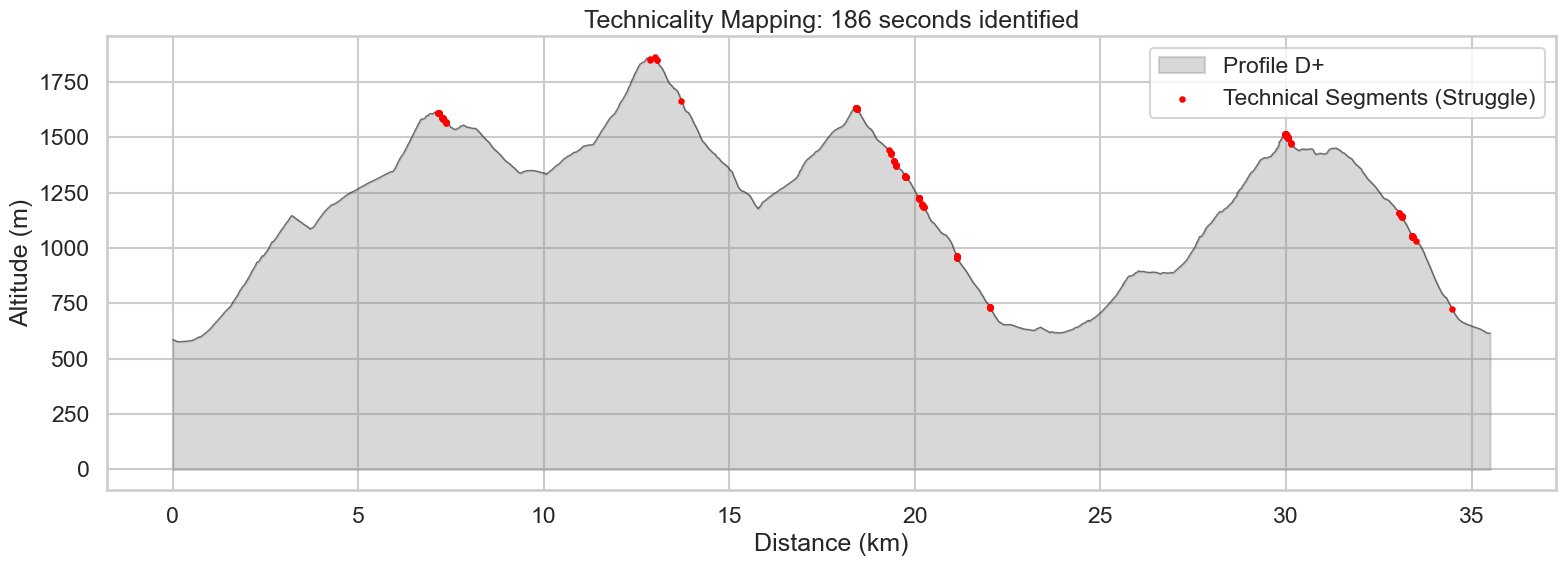

In [9]:
# =============================================================================
# VISUALIZATION: TECHNICALITY MAPPING
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 6))

# 1. The Altitude Profile (Gray Background)
ax.fill_between(df['distance']/1000, df['alt_smooth'], color='gray', alpha=0.3, label='Profile D+')
ax.plot(df['distance']/1000, df['alt_smooth'], color='black', linewidth=1, alpha=0.5)

# 2. Technical Zones (Red Highlight)
# We filter only points identified as technical
technical_mask = df['is_technical_segment']
ax.scatter(df.loc[technical_mask, 'distance']/1000, 
           df.loc[technical_mask, 'alt_smooth'], 
           color='red', s=10, label='Technical Segments (Struggle)', zorder=5)

ax.set_title(f'Technicality Mapping: {technical_mask.sum()} seconds identified')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Altitude (m)')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

Red dots = technical terrain

## III/ PERFORMANCE ANALYSIS (continue reading from here)

🥪 4 Consolidated aid stations.


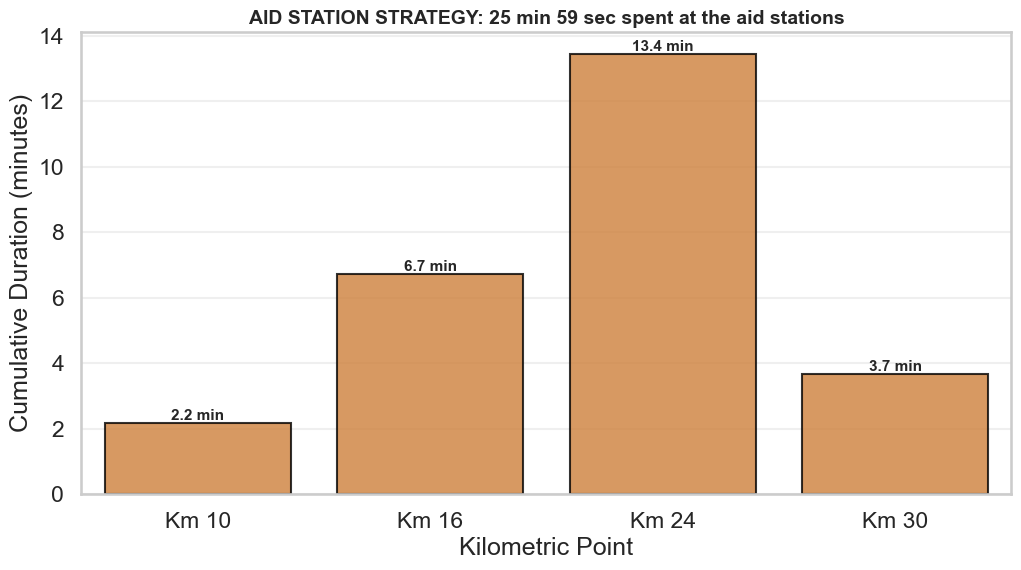

In [10]:
# =============================================================================
# 6. ANALYSIS OFES RAVITOS 
# =============================================================================

# 1. Initial detection 
df_stops = df_raw.copy()
STOP_SPEED_THRESHOLD = 1.0 
MIN_DURATION_MIN = 2.0      

df_stops['speed_kmh'] = df_stops['speed'] * 3.6
df_stops['is_stopped'] = df_stops['speed_kmh'] < STOP_SPEED_THRESHOLD
df_stops['group_id'] = (df_stops['is_stopped'] != df_stops['is_stopped'].shift()).cumsum()

stops_list = []
for group_id, group_data in df_stops.groupby('group_id'):
    if group_data['is_stopped'].iloc[0]:
        start_time = group_data['time'].iloc[0]
        end_time = group_data['time'].iloc[-1]
        duration_min = (end_time - start_time).total_seconds() / 60.0
        
        if duration_min >= MIN_DURATION_MIN:
            km_point = group_data['distance'].mean() / 1000
            stops_list.append({
                'km': km_point,
                'duration_min': duration_min,
                'start_time': start_time,
                'label': f"Km {int(round(km_point))}"
            })

df_ravitos_raw = pd.DataFrame(stops_list)

# --- DUPLICATE MERGE (AGGREGATION) ---
if not df_ravitos_raw.empty:
    # Group by Label (e.g. "Km 24") and sum durations
    # We keep the earliest 'start_time' for chronological order
    df_ravitos = df_ravitos_raw.groupby('label', as_index=False).agg({
        'duration_min': 'sum',      # We SUM the times (2.1 + 11.3 = 13.4)
        'km': 'mean',
        'start_time': 'min'         # We keep the time of the first stop
    }).sort_values('start_time')    # We put back in race order

    print(f"🥪 {len(df_ravitos)} Consolidated aid stations.")
    
    # 2. Visualization
    plt.figure(figsize=(12, 6))
    
    ax = sns.barplot(
        data=df_ravitos,
        x='label',
        y='duration_min',
        color='#e67e22',
        edgecolor='black',
        alpha=0.8
        # No more error here because there is only one line per aid station
    )
    
    total_time = df_ravitos['duration_min'].sum()
    plt.title(f'AID STATION STRATEGY: {int(total_time)} min {int((total_time%1)*60)} sec spent at the aid stations', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Cumulative Duration (minutes)')
    plt.xlabel('Kilometric Point')
    plt.grid(axis='y', alpha=0.3)
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f} min', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', 
                    fontweight='bold', fontsize=11)
        
    plt.show()
    

else:
    print("🚫 No stop detected.")

Overall the aid stations were managed better than on my first trail but I need to be more consistent. Maybe take 5 mins at each and not have such a high std.

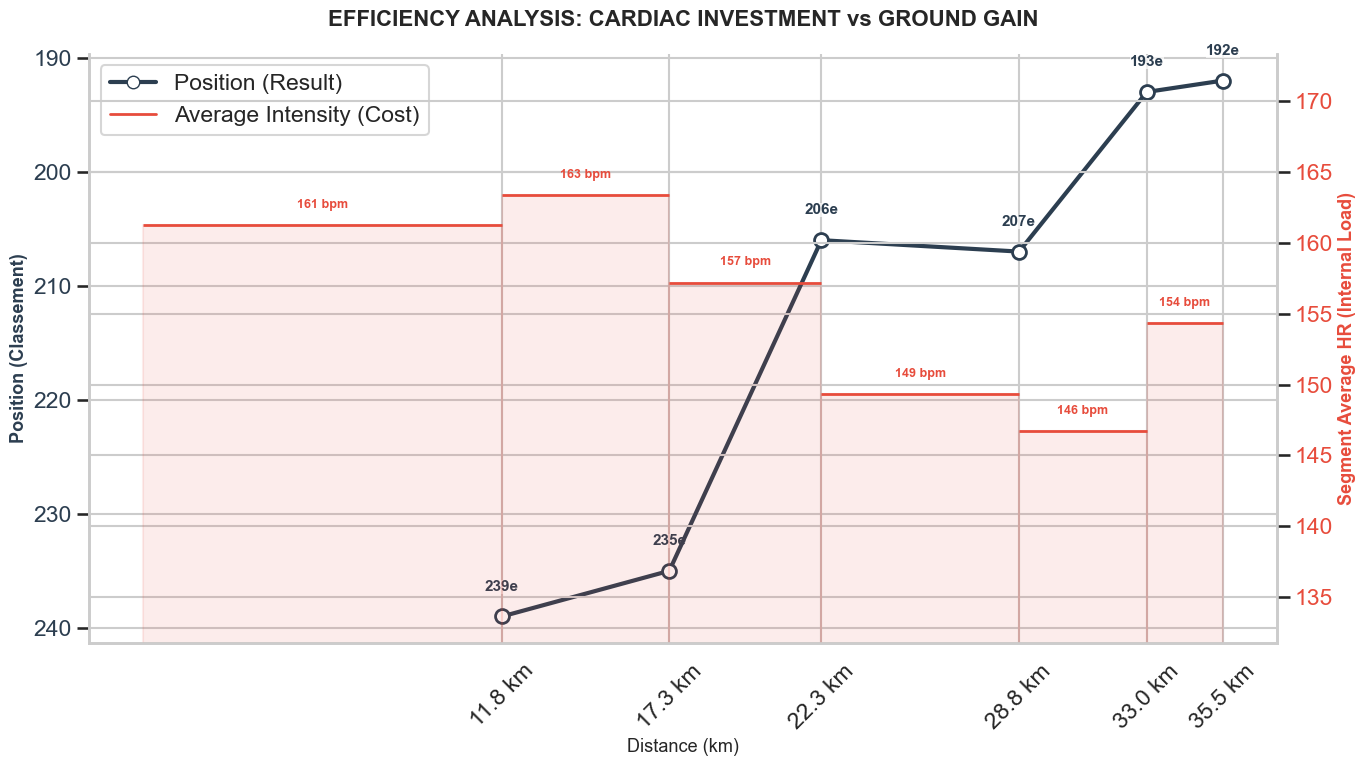

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# =============================================================================
# 1. DATA PREP (IDENTIQUE)
# =============================================================================

data_checkpoints = {
    'km': [11.8, 17.3, 22.3, 28.8, 33.0, 35.5],
    'rank': [239, 235, 206, 207, 193, 192]
}
df_pacing = pd.DataFrame(data_checkpoints)

# Calcul Average HR (Identique)
hr_segment_means = []
prev_km = 0

for current_km in df_pacing['km']:
    start_m = prev_km * 1000
    end_m = current_km * 1000
    segment_mask = (df['distance'] > start_m) & (df['distance'] <= end_m)
    
    if segment_mask.sum() > 0:
        avg_hr = df.loc[segment_mask, 'heart_rate'].mean()
    else:
        avg_hr = np.nan
        
    hr_segment_means.append(avg_hr)
    prev_km = current_km

df_pacing['segment_avg_hr'] = hr_segment_means

# =============================================================================
# 2. ADVANCED VISUALIZATION: BLOCKS vs POINTS
# =============================================================================

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# --- AXIS 1 (LEFT): THE RESULT (LINE) ---
ax1 = plt.gca()

# We draw the ranking line (Evolution)
line1 = ax1.plot(df_pacing['km'], df_pacing['rank'], 
         color='#2c3e50',       
         linewidth=3,
         marker='o',
         markersize=10, 
         markerfacecolor='white', 
         markeredgecolor='#2c3e50',
         markeredgewidth=2,
         label='Position (Rank)',
         zorder=10)

ax1.invert_yaxis()
ax1.set_ylabel("Position (Classement)", fontsize=13, fontweight='bold', color='#2c3e50')
ax1.set_xlabel("Distance (km)", fontsize=13)
ax1.tick_params(axis='y', labelcolor='#2c3e50')

# --- AXIS 2 (RIGHT): THE COST (BLOCKS / PLATEAUS) ---
ax2 = ax1.twinx()

# We loop to manually draw each "Plateau"
prev_km = 0
hr_patches = [] # For the legend

# Block color
hr_color = '#e74c3c'

for i in range(len(df_pacing)):
    current_km = df_pacing['km'].iloc[i]
    hr = df_pacing['segment_avg_hr'].iloc[i]
    
    if pd.notna(hr):
        # 1. The horizontal line (Effort level)
        ax2.hlines(y=hr, xmin=prev_km, xmax=current_km, 
                   colors=hr_color, linewidth=2, linestyle='-')
        
        # 2. Filled shadow (The "quantity" of effort) - Optional but stylish
        ax2.fill_between([prev_km, current_km], [hr, hr], 0, 
                         color=hr_color, alpha=0.1) # Low alpha to not hide grid
        
        # 3. Label of the value in the middle of the segment
        mid_point = (prev_km + current_km) / 2
        ax2.text(mid_point, hr + 1, f"{int(hr)} bpm", 
                 ha='center', va='bottom', 
                 fontsize=9, fontweight='bold', color=hr_color)
        
    prev_km = current_km

# HR Axis Setup
ax2.set_ylabel("Segment Average HR (Internal Load)", fontsize=13, fontweight='bold', color=hr_color)
ax2.tick_params(axis='y', labelcolor=hr_color)

# Scale adjustment so blocks "float" well
hr_min = df_pacing['segment_avg_hr'].min()
hr_max = df_pacing['segment_avg_hr'].max()
ax2.set_ylim(hr_min - 15, hr_max + 10) 

# --- RANKING ANNOTATIONS ---
for i in range(len(df_pacing)):
    km = df_pacing['km'].iloc[i]
    rank = df_pacing['rank'].iloc[i]
    ax1.text(km, rank -2 , f"{rank}e", ha='center', va='bottom', 
             fontsize=11, fontweight='bold', color='#2c3e50',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0))

# --- TITLES & LEGEND ---
plt.title("EFFICIENCY ANALYSIS: CARDIAC INVESTMENT vs GROUND GAIN", fontsize=16, fontweight='bold', pad=20)

# Hack for custom legend (since we drew lines manually)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#2c3e50', lw=3, marker='o', markerfacecolor='white', label='Position (Result)'),
    Line2D([0], [0], color=hr_color, lw=2, label='Average Intensity (Cost)')
]
ax1.legend(handles=legend_elements, loc='upper left', frameon=True)

# Force X-ticks to clearly see delimitations
ax1.set_xticks(df_pacing['km'])
ax1.set_xticklabels([f"{x} km" for x in df_pacing['km']], rotation=45)

sns.despine(right=False, top=True)

plt.tight_layout()
plt.show()

Here we can clearly see the different phases of the race. I started with a pretty high heart rate until km 17.3. Then my HR declined steadily until km 33. It's something I felt during the race, at the stop at km 17.3 I was telling myself "maybe I started out too quick" and I felt anxious considering I still had half the race in front of me. So I lifted my foot off the gas a bit during the part between km 17 and 22, but still, it wasn't enough to properly recover. So I tried to hang on and keep the same intensity until the end of the race. What's interesting is that while my RPE was constant between km 17.3 and 33, my HR steadily declined. During this part of the race I felt as if I was pushing but had no fuel in the tank, my HR was quite low but I was unable to make it climb higher. This is an interesting phenomenon that I felt during all my races, I will try to understand it more in the future. During the last part of the race, excited by the finish line, I was able to accelerate a bit as my HR shows (+8 bpm).

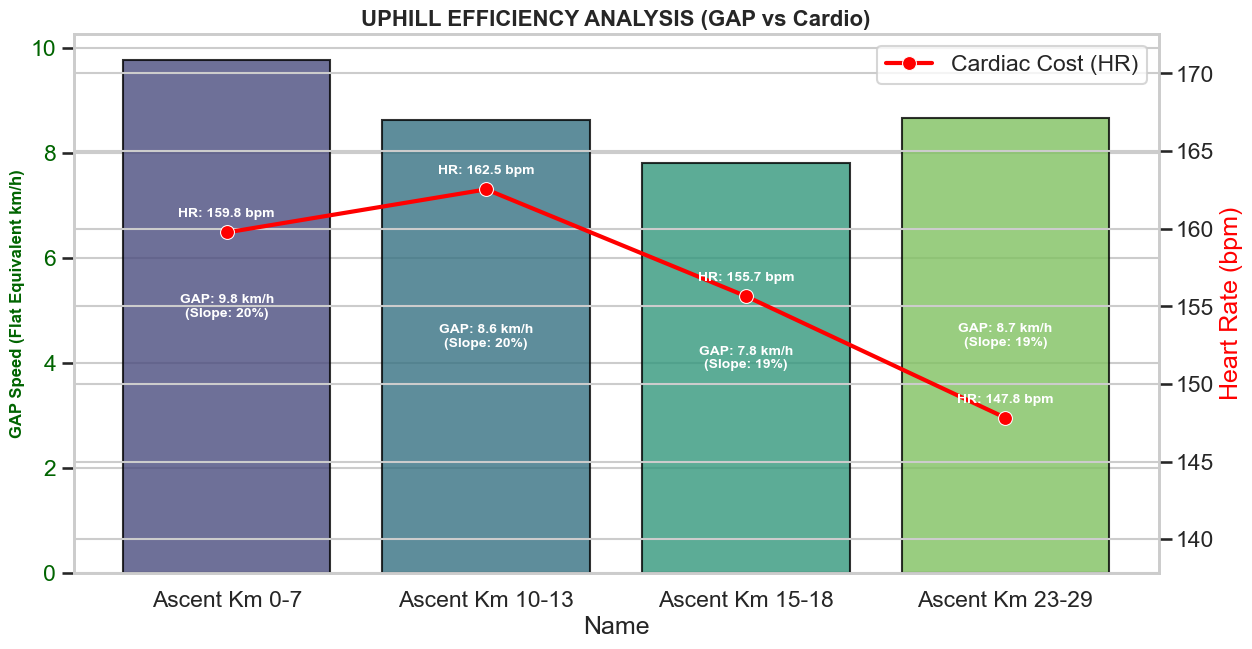

GAP EVOLUTION :
   - First climb: 9.8 km/h (Flat Eq.)
   - Last climb: 8.7 km/h (Flat Eq.)
 DECLINE: Significant drop in engine power.


In [12]:
# =============================================================================
# 11. UPHILL ANALYSIS
# =============================================================================

# 2. GAP calculation on entire dataframe
df_raw['gap_factor'] = df_raw['grade'].apply(get_gap_factor)
df_raw['gap_speed_kmh'] = (df_raw['speed'] * df_raw['gap_factor']) * 3.6

# 3. Recovery of Ascents (Same logic as block 7)
def get_climb_stats(df, min_gain=80):
    # Altitude smoothing
    alt_smooth = df['altitude'].rolling(100, center=True).mean().bfill().ffill()
    
    # Peaks and Troughs
    peaks, _ = find_peaks(alt_smooth, prominence=50, distance=100)
    valleys, _ = find_peaks(-alt_smooth, prominence=50, distance=100)
    extrema = sorted([(i, 'valley') for i in valleys] + [(i, 'peak') for i in peaks])
    
    # Start fix
    if not extrema or extrema[0][1] == 'peak': extrema.insert(0, (0, 'valley'))
        
    climb_data = []
    
    for i in range(len(extrema) - 1):
        idx_start, type_start = extrema[i]
        idx_end, type_end = extrema[i+1]
        
        if type_start == 'valley' and type_end == 'peak':
            gain = alt_smooth.iloc[idx_end] - alt_smooth.iloc[idx_start]
            
            if gain >= min_gain:
                km_start = df['distance'].iloc[idx_start] / 1000
                km_end = df['distance'].iloc[idx_end] / 1000
                
                # Segment isolation
                mask = (df.index >= idx_start) & (df.index <= idx_end)
                subset = df[mask]
                
                climb_data.append({
                    'Name': f"Ascent Km {int(km_start)}-{int(km_end)}",
                    'GAP_Moy': subset['gap_speed_kmh'].mean(),
                    'VAM_Moy': (gain / (subset['time'].iloc[-1] - subset['time'].iloc[0]).total_seconds()) * 3600,
                    'HR_Moy': subset['heart_rate'].mean(),
                    'Pente_Moy': subset['grade'].mean() * 100,
                    'D+': int(gain)
                })
                
    return pd.DataFrame(climb_data)

df_climbs_gap = get_climb_stats(df_raw)

# 4. Comparative Visualization
if not df_climbs_gap.empty:
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Bars: GAP (Real Power)
    # Color: Green (Efficient) -> Red (Tired)
    sns.barplot(data=df_climbs_gap, x='Name', y='GAP_Moy', 
                palette='viridis', alpha=0.8, ax=ax1, edgecolor='black')
    
    ax1.set_ylabel("GAP Speed (Flat Equivalent km/h)", color='darkgreen', fontsize=12, fontweight='bold')
    ax1.set_title("UPHILL EFFICIENCY ANALYSIS (GAP vs Cardio)", fontsize=16, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='darkgreen')
    
    # Line: HR (The Cost)
    ax2 = ax1.twinx()
    sns.lineplot(data=df_climbs_gap, x='Name', y='HR_Moy', 
                 color='red', marker='o', markersize=10, linewidth=3, ax=ax2, label='Cardiac Cost (HR)')
    ax2.set_ylabel("Heart Rate (bpm)", color='red')
    ax2.set_ylim(df_climbs_gap['HR_Moy'].min() - 10, df_climbs_gap['HR_Moy'].max() + 10)
   

   
    # Annotations on bars
    for i, row in df_climbs_gap.iterrows():
        ax1.text(i, row['GAP_Moy']/2, f"GAP: {row['GAP_Moy']:.1f} km/h\n(Slope: {row['Pente_Moy']:.0f}%)", 
                 color='white', ha='center', fontweight='bold', fontsize=10)
        ax2.text(i, row['HR_Moy'] + 1, f"HR: {row['HR_Moy']:.1f} bpm", 
                 color='white', ha='center', fontweight='bold', fontsize=10)
    plt.show()
    
    # 5. Diagnostic
    print("GAP EVOLUTION :")
    first_gap = df_climbs_gap.iloc[0]['GAP_Moy']
    last_gap = df_climbs_gap.iloc[-1]['GAP_Moy']
    
    print(f"   - First climb: {first_gap:.1f} km/h (Flat Eq.)")
    print(f"   - Last climb: {last_gap:.1f} km/h (Flat Eq.)")
    
    if last_gap > first_gap:
        print(" POWERFUL NEGATIVE SPLIT: I finished stronger than I started !")
    elif (first_gap - last_gap) / first_gap < 0.10:
        print(" SOLID PACING : Low power loss (<10%).")
    else:
        print(" DECLINE: Significant drop in engine power.")

else:
    print("No ascent detected.")

Now we compare each climb to see how my GAP evolved (and compare it to my HR). The difference between climbs is much smaller than on my first trail, once again an indicator that I managed to pace my race quite well. My HR fell during the race, I always feel this, at the same RPE my heart rate diminishes during the race. Quite counter-intuitive.

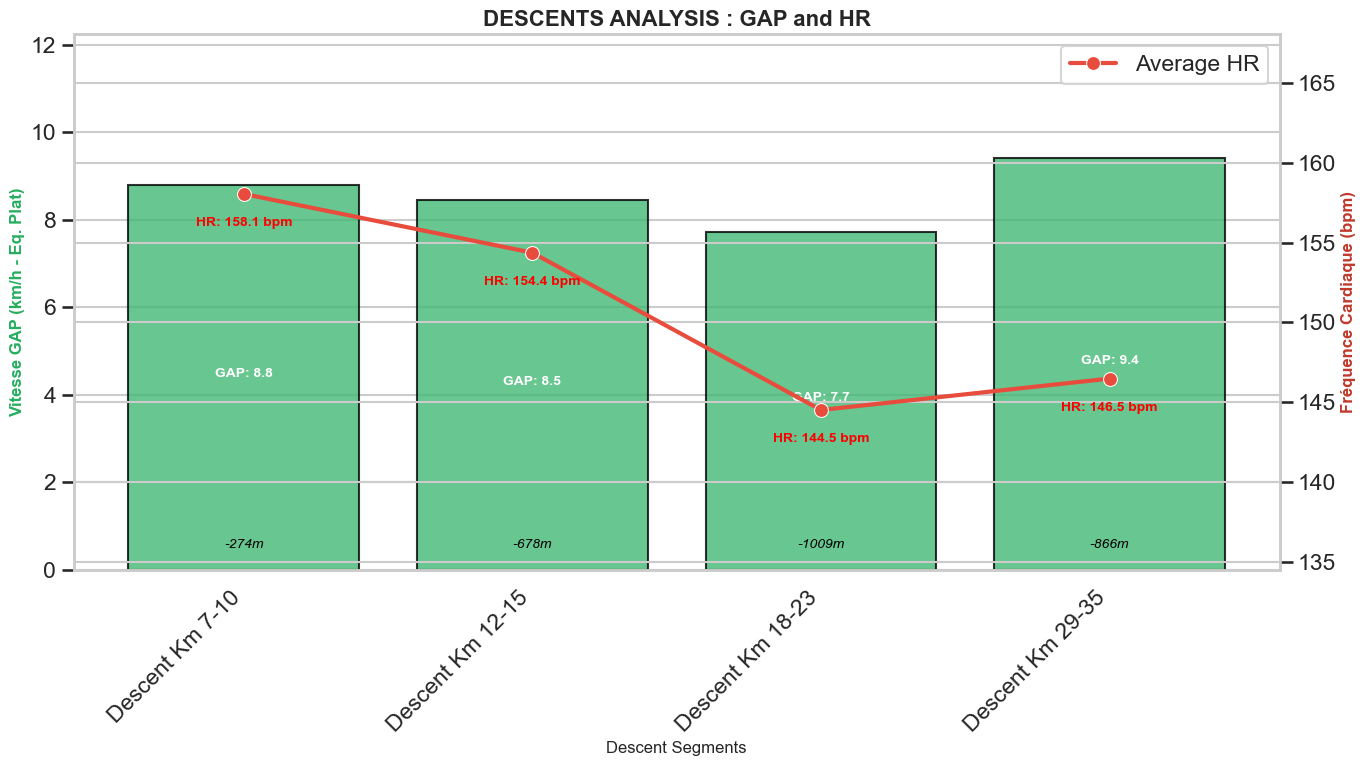

,Block,Avg GAP Speed (km/h),Avg Raw Speed (km/h),Avg HR (bpm),Loss (m)
0,Descent Km 7-10,8.788844,8.359716,158.055643,274
1,Descent Km 12-15,8.451793,5.898193,154.371686,678
2,Descent Km 18-23,7.724369,5.970124,144.517306,1009
3,Descent Km 29-35,9.410812,7.483407,146.485256,866


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks

# =============================================================================
# 10. DESCENT SPEED ANALYSIS 
# =============================================================================

def detect_descents_blocks_v2(df, min_loss_m=50, smoothing_window=200):
    # Smoothing
    alt_macro = df['altitude'].rolling(window=smoothing_window, center=True).mean().bfill().ffill()
    
    # Inversion to use the same logic as ascents
    inv_alt = -alt_macro
    peaks, _ = find_peaks(inv_alt, prominence=50, distance=100) # Real valleys
    valleys, _ = find_peaks(-inv_alt, prominence=50, distance=100) # Real peaks
    
    extrema = sorted([(i, 'peak') for i in peaks] + [(i, 'valley') for i in valleys])
    
    # END OF THE RACE MANAGEMENT 
    # If the last extremum is a peak (valley in our inverted logic),
    # and that the end altitude is lower, we add the end as a trough.
    if extrema and extrema[-1][1] == 'valley':
        last_idx = len(df) - 1
        if alt_macro.iloc[last_idx] < alt_macro.iloc[extrema[-1][0]]:
             extrema.append((last_idx, 'peak')) # 'peak' here = real trough (low altitude)

    segments = []
    for i in range(len(extrema) - 1):
        idx_start, type_start = extrema[i]
        idx_end, type_end = extrema[i+1]
        
        # Looking for Peak -> Trough sequence
        # In our inverted logic: Valley (-inv_alt) -> Peak (inv_alt)
        # But we especially verify the real D-
        
        start_alt = alt_macro.iloc[idx_start]
        end_alt = alt_macro.iloc[idx_end]
        
        if start_alt > end_alt: # It is indeed a descent
            loss = start_alt - end_alt
            
            if loss >= min_loss_m:
                km_start = df['distance'].iloc[idx_start] / 1000
                km_end = df['distance'].iloc[idx_end] / 1000
                
                # Data Extraction
                mask = (df['distance'] >= km_start*1000) & (df['distance'] <= km_end*1000)
                subset = df[mask]
                
                if len(subset) > 0:
                    # Calculation of average Enduraw GAP speed
                    # We apply the Enduraw model on each point of the segment, then average
                    
                    # 1. Calculation of GAP factor for each point (if not already done globally)
                    # Enduraw Polynomial reverse-engineered
                    
                    subset_factors = subset['grade'].apply(get_gap_factor)
                    subset_gap_speeds = (subset['speed'] * subset_factors) * 3.6 # km/h
                    
                    avg_gap_speed = subset_gap_speeds.mean()
                    avg_raw_speed = subset['speed'].mean() * 3.6
                    avg_hr = subset['heart_rate'].mean()
                    
                    segments.append({
                        'Block': f"Descent Km {int(km_start)}-{int(km_end)}",
                        'Start Km': km_start,
                        'End Km': km_end,
                        'Loss (m)': int(loss),
                        'Avg GAP Speed (km/h)': avg_gap_speed, 
                        'Avg Raw Speed (km/h)': avg_raw_speed, 
                        'Avg HR (bpm)': avg_hr
                    })
    
    return pd.DataFrame(segments)


df_descent_final = detect_descents_blocks_v2(df_raw, min_loss_m=80) 

if not df_descent_final.empty:
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # GAP Speed Bars (Enduraw)
    sns.barplot(data=df_descent_final, x='Block', y='Avg GAP Speed (km/h)', 
                color='#2ecc71', alpha=0.8, ax=ax1, edgecolor='black', label='GAP Speed (Equivalent Effort)')
    
    # sns.barplot(data=df_descent_final, x='Block', y='Avg Raw Speed (km/h)', 
    #             color='gray', alpha=0.3, ax=ax1, edgecolor='black', label='Real Speed')

    ax1.set_ylabel("Vitesse GAP (km/h - Eq. Plat)", color='#27ae60', fontsize=12, fontweight='bold')
    ax1.set_xlabel("Descent Segments", fontsize=12)
    ax1.set_title("DESCENTS ANALYSIS : GAP and HR", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # HR Line
    ax2 = ax1.twinx()
    sns.lineplot(data=df_descent_final, x='Block', y='Avg HR (bpm)', 
                 color='#e74c3c', marker='o', markersize=10, linewidth=3, ax=ax2, label='Average HR')
    
    ax2.set_ylabel("Fréquence Cardiaque (bpm)", color='#c0392b', fontsize=12, fontweight='bold')
    
    # Annotations
    for i, row in df_descent_final.iterrows():
        # GAP Label
        ax1.text(i, row['Avg GAP Speed (km/h)']/2, f"GAP: {row['Avg GAP Speed (km/h)']:.1f}", 
                 color='white', ha='center', fontweight='bold', fontsize=10)
        # Elevation
        ax1.text(i, 0.5, f"-{row['Loss (m)']}m", 
                 color='black', ha='center', fontsize=10, style='italic')
        ax2.text(i, row['Avg HR (bpm)']-2, f"HR: {row['Avg HR (bpm)']:.1f} bpm",
                color='red', ha='center', fontweight='bold', fontsize=10)
                 
    # Scales
    ax1.set_ylim(0, df_descent_final['Avg GAP Speed (km/h)'].max() * 1.3)
    if not df_descent_final['Avg HR (bpm)'].isnull().all():
        min_hr = df_descent_final['Avg HR (bpm)'].min()
        max_hr = df_descent_final['Avg HR (bpm)'].max()
        ax2.set_ylim(min_hr - 10, max_hr + 10)

    # Legend to differentiate GAP and HR
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
  

    plt.tight_layout()
    plt.show()
    
    display(df_descent_final[['Block', 'Avg GAP Speed (km/h)', 'Avg Raw Speed (km/h)', 'Avg HR (bpm)', 'Loss (m)']].style.background_gradient(cmap='Greens', subset=['Avg GAP Speed (km/h)']))
else:
    print("No descent detected.")

Now let's compare the descents, same thing as the climbs: regular. I even managed to accelerate a bit during the last one to climb a bit in the ranking.

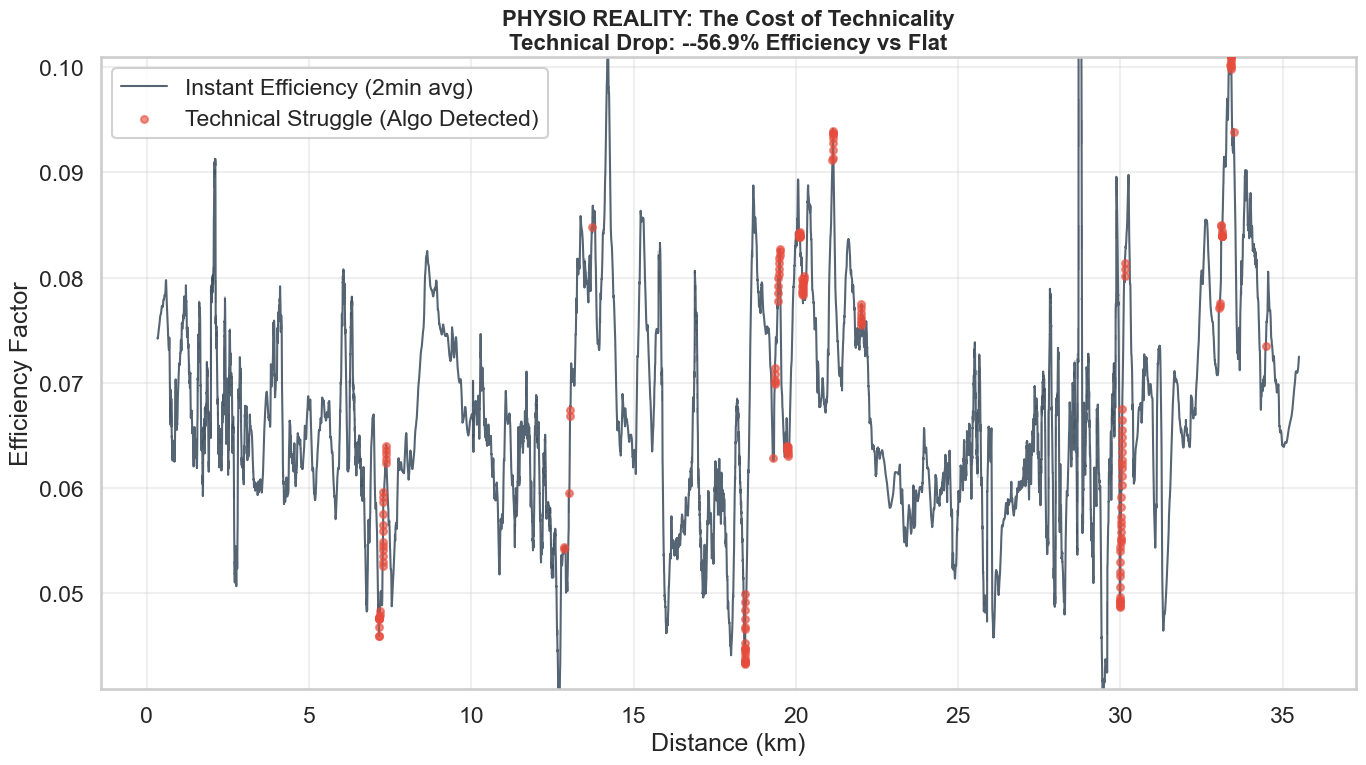

📉 IMPACT ANALYSIS :
   Efficiency drop on technical analysis : --56.9%


In [14]:
# =============================================================================
# 3. VISUALIZATION - THE "SCATTER OVERLAY" (Clean Version)
# =============================================================================

plt.figure(figsize=(14, 8))

# 1. DATA PREP
# A. La "Vérité Terrain" (Responsive) : Lissage court (2 min)
df['ef_responsive'] = df['efficiency_idx'].rolling(window=2*60).mean()
df['distance_km'] = df['distance'] / 1000

# B. Filtering Technical Points
# On sélectionne uniquement les points flaggés techniques qui ont une valeur lissée valide
tech_points = df[(df['is_technical_segment']) & (df['ef_responsive'].notna())]

# 2. PLOTTING
# A. Main Curve (The Performance)
sns.lineplot(
    data=df, 
    x='distance_km', 
    y='ef_responsive', 
    color='#2c3e50', 
    linewidth=1.5, 
    alpha=0.8, 
    label='Instant Efficiency (2min avg)'
)

# B. Technical Overlay (The "Infection")
# On superpose des points rouges directement sur la courbe bleue
plt.scatter(
    x=tech_points['distance_km'], 
    y=tech_points['ef_responsive'], 
    color='#e74c3c',       
    s=25,                  
    alpha=0.6,             
    label='Technical Struggle (Algo Detected)',
    zorder=3               
)

# 3. METRICS & ANNOTATIONS
# Calcul du Delta Technique
mean_tech_ef = df[df['is_technical_segment']]['efficiency_idx'].mean()
mean_easy_ef = df[~df['is_technical_segment']]['efficiency_idx'].mean()
tech_cost = (mean_easy_ef - mean_tech_ef) / mean_easy_ef * 100

plt.title(f"PHYSIO REALITY: The Cost of Technicality\nTechnical Drop: -{tech_cost:.1f}% Efficiency vs Flat", fontsize=16, fontweight='bold')
plt.xlabel("Distance (km)") 
plt.ylabel("Efficiency Factor")
plt.legend(loc='upper left', framealpha=0.9)
plt.grid(True, alpha=0.3)

# Zoom sur l'axe Y (Nettoyage visuel des extrêmes)
q_low = df['ef_responsive'].quantile(0.05)
q_high = df['ef_responsive'].quantile(0.95)
plt.ylim(q_low * 0.8, q_high * 1.2)

plt.tight_layout()
plt.show()

# 4. DIAGNOSTIC TERMINAL
print(f"📉 IMPACT ANALYSIS :")
print(f"   Efficiency drop on technical analysis : -{tech_cost:.1f}%")



And now the efficiency index. It's coherent that my efficiency was almost the same during the race because I managed my climbs and descents very well, not pushing myself to the redzone. This helped me to finish strongly. It's interesting to see this because during the race I felt as if I had completely exploded, the data here shows me another story. Red dots here are the technical parts of the race, we can clearly see that technicality correlates very strongly with low efficiency (or efficiency that's decreasing). 

## IV/ Global Analysis

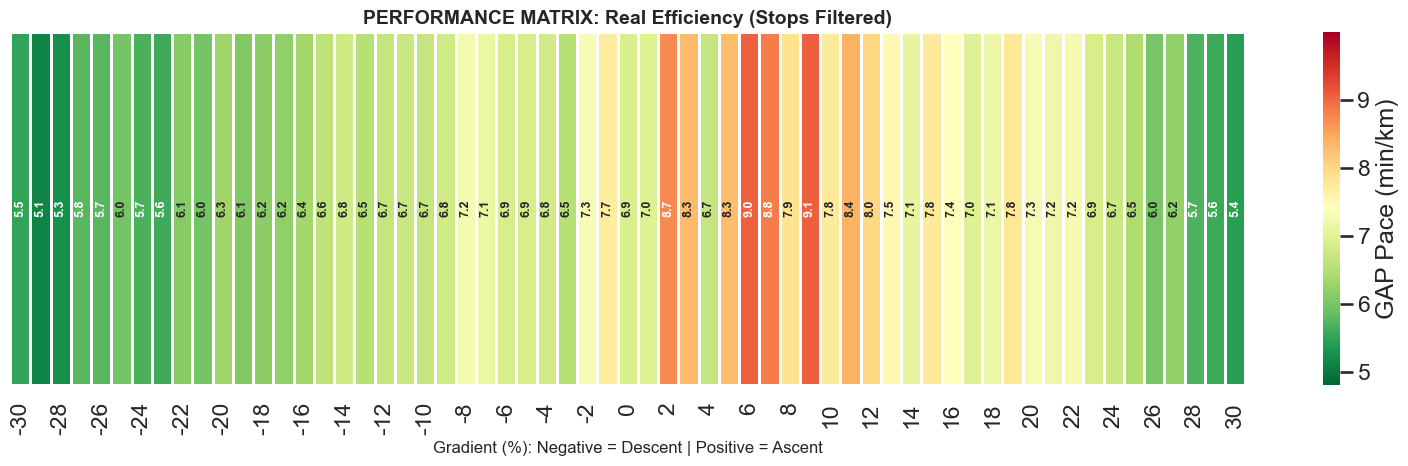

📊 Slope vs GAP Correlation : 0.09
   -> Tendance : Balanced Profile.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. DATA PREP & CLEANING ---
# Calculation of slope in %
df_pace['slope_pct'] = df_pace['grade'] * 100
df_pace['slope_bin'] = df_pace['slope_pct'].round().astype(int)

# CRITICAL FILTER (Anti-Noise):
# We keep only 'active' paces (< 20 min/km or > 3 km/h)
# This eliminates aid stations and pee breaks that skew the average to 0%
mask_active = (df_pace['gap_pace'] < 20) & (df_pace['gap_pace'] > 3) # >3 to avoid GPS bugs (3 min/km)
df_viz = df_pace[mask_active]

# We restrict the useful slope window (-30% to +30%)
df_viz = df_viz[(df_viz['slope_bin'] >= -30) & (df_viz['slope_bin'] <= 30)]

# --- 2. MATRIX CALCULATION ---
heatmap_data = df_viz.groupby('slope_bin')[['gap_pace']].median().T

# --- 3. COLOR CALIBRATION (Quantiles) ---
v_min = df_viz['gap_pace'].quantile(0.05) # Top 5% (Dark Green)
v_max = df_viz['gap_pace'].quantile(0.85) # Bottom 15% (Dark Red)

# --- 4. VISUALIZATION ---
plt.figure(figsize=(16, 5))

sns.heatmap(
    heatmap_data,
    cmap='RdYlGn_r', # Inverted: Green = Small number (Fast), Red = Large number (Slow)
    annot=True,
    fmt=".1f",
    vmin=v_min,      # Calibrated Lower Bound
    vmax=v_max,      # Calibrated Upper Bound
    cbar_kws={'label': 'GAP Pace (min/km)'},
    linewidths=1,
    square=False,
    annot_kws={"rotation": 90, "size": 9, "weight": "bold"}
)

plt.title("PERFORMANCE MATRIX: Real Efficiency (Stops Filtered)", fontweight='bold', fontsize=14)
plt.xlabel("Gradient (%): Negative = Descent | Positive = Ascent", fontsize=12)
plt.yticks([]) # Hides Y axis

plt.tight_layout()
plt.show()

# --- 5. STATISTICAL ANALYSIS ---
corr = df_viz[['slope_pct', 'gap_pace']].corr().iloc[0, 1]
print(f"📊 Slope vs GAP Correlation : {corr:.2f}")
if corr > 0.5:
    print("   -> Tendance : I lose efficiency uphill.")
elif corr < -0.5:
    print("   -> Tendance : I perform better uphill than in descents.")
else:
    print("   -> Tendance : Balanced Profile.")


Applying Enduraw's GAP to every gradient I was able to compare my performance from -30° to 30°. Here I seemed the strongest during steep parts (descents AND climbs). However, my clear weak spots are moderate inclines, where I walk too soon, or I try to run and end up pushing myself too much, tricky! The correlation factor indicates that I'm a bit stronger during descents than ascents, which is also my feeling on the trails.

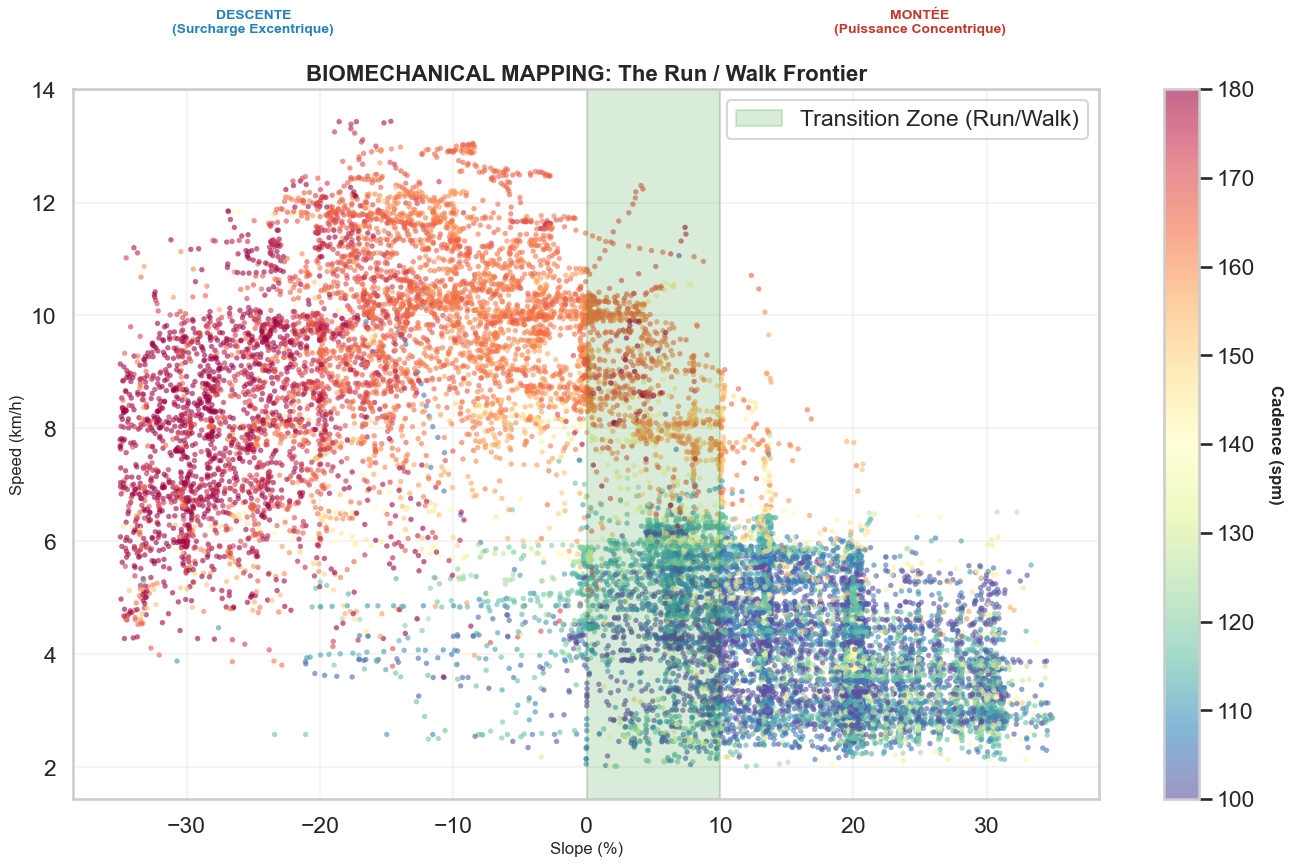

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# 13. BIOMECHANICAL ANALYSIS: RUN / HIKE TRANSITION
# =============================================================================

# A. Data Preparation (Using existing clean data)
df_bio = df.copy()

# Slope Conversion to % 
df_bio['slope_pct'] = df_bio['grade'] * 100
df_bio['speed_kmh'] = df_bio['speed'] * 3.6

# B. Smart Filtering
# We exclude stops (speed < 1km/h) and slope aberrations (GPS jumping)
mask_bio = (
    (df_bio['speed_kmh'] > 1.0) & 
    (df_bio['speed_kmh'] < 25.0) &
    (df_bio['slope_pct'] > -35) & 
    (df_bio['slope_pct'] < 35) &
    (df_bio['cadence'] > 30) # We exclude pee/shoelace breaks
)
data_viz = df_bio[mask_bio]

# C. Visualisation
plt.figure(figsize=(14, 9))

# Scatter Plot: Cadence is the judge
# < 120-130: Walk | > 160: Run
scatter = plt.scatter(
    x=data_viz['slope_pct'],
    y=data_viz['speed_kmh'],
    c=data_viz['cadence'],
    cmap='Spectral_r', # Blue (Walk/Slow) -> Red (Run/Fast)
    s=15,
    alpha=0.6,
    edgecolor='none',
    vmin=100, # Lower Bound (Brisk Walk)
    vmax=180  # Upper Bound (Dynamic Run)
)

# D. Critical Zones
# Physiological "Crossover" transition zone (usually between 12% and 15%)
# Addition of transition zone (e.g. from 0% to 15% slope)
plt.axvspan(0, 10, color='green', alpha=0.15, label='Transition Zone (Run/Walk)')


# E. Aesthetics & Legends
cbar = plt.colorbar(scatter)
cbar.set_label('Cadence (spm)', rotation=270, labelpad=20, fontsize=12, fontweight='bold')

plt.title("BIOMECHANICAL MAPPING: The Run / Walk Frontier", fontsize=16, fontweight='bold')
plt.xlabel("Slope (%)", fontsize=12)
plt.ylabel("Speed (km/h)", fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend(loc='upper right')

# Annotations to guide the eye
plt.text(-25, 15, "DESCENTE\n(Surcharge Excentrique)", fontsize=10, fontweight='bold', color='#2980b9', ha='center')
plt.text(25, 15, "MONTÉE\n(Puissance Concentrique)", fontsize=10, fontweight='bold', color='#c0392b', ha='center')

plt.tight_layout()
plt.show()

This run/walk analysis perfectly compliments my performance matrix: I start to walk very soon (almost as soon as gradient becomes positive). I need to work on that to improve my performances.